# Using Deep Learning approach 
Without dimensionality reduction based approach

## Reading the data

In [3]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p  drive
!google-drive-ocamlfuse drive

In [5]:
!ls

adc.json  drive  sample_data


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
plt.style.use('ggplot')
% matplotlib inline

In [0]:
data_train = pd.read_csv('drive/data/training.csv')

In [0]:
data_test = pd.read_csv('drive/data/test.csv')

In [163]:
print(data_train.shape, data_test.shape)

(7049, 31) (1783, 2)


In [164]:
print(data_train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [165]:
data_train.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [166]:
data_train.keys()

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

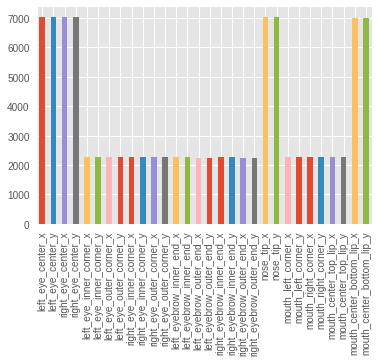

In [167]:
data_train.describe().loc['count'].plot.bar()

In [168]:
data_train = data_train.dropna()
data_train.shape

(2140, 31)

In [0]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces_with_keypoints(df, nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    keypoint_cols = list(df.columns)[:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

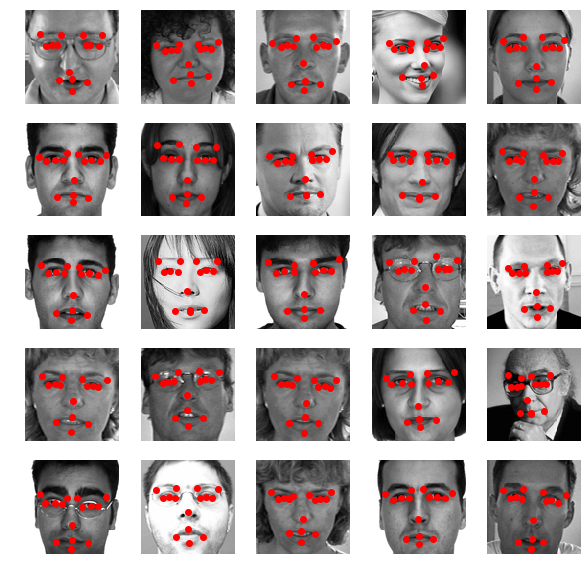

In [170]:
plot_faces_with_keypoints(data_train)

In [171]:
train_key_points_y = np.array(data_train.iloc[:,0:-1]).astype(np.float32)
train_images = data_train.iloc[:,-1]
test_images = data_test.iloc[:, -1]
np.max(train_key_points_y), np.min(train_key_points_y)

(95.80898, 3.8262432)

In [0]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler

# output_pipe = make_pipeline(
#     MinMaxScaler(feature_range=(-1, 1))
# )

# train_keypoints = output_pipe.fit_transform(train_key_points_y)
train_keypoints = (train_key_points_y - 48)/48

In [173]:
np.min(train_keypoints), np.max(train_keypoints)

(-0.9202866, 0.9960205)

In [174]:
train_images = train_images.reshape(-1,1)
test_images = test_images.reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [175]:
print(train_images.shape, test_images.shape, train_keypoints.shape)

(2140, 1) (1783, 1) (2140, 30)


In [0]:
def reform_data(img_str):
    t1 = img_str[0].split()
    t2 = np.array(t1).astype(np.float32)
    t3 = t2.reshape(96,96,1)
    return t3/255
train_images = np.apply_along_axis(reform_data,1, train_images)
test_images = np.apply_along_axis(reform_data,1, test_images)

In [177]:
print(train_images.shape, test_images.shape, train_keypoints.shape)

(2140, 96, 96, 1) (1783, 96, 96, 1) (2140, 30)


### The images are stored in test_image, train_image which is a 96x96 dimensional vector converted image and all the X and Y coordinates of key point features is mentioned in train_key_points, test_key_points
### The key features are 
'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'

In [0]:
# Free the memory
del data_test
del data_train

[66.8128, 29.9872, 60.02, 73.9632, 35.3504, 22.1216, 56.444, 80.756, 35.3504, 14.9712, 46.076, 60.7344, 33.2048, 46.4336, 46.076] [38.1092, 37.03664, 38.46672, 39.53936, 38.1092, 38.46672, 29.17104, 30.95872, 28.81352, 29.88608, 52.4104, 77.0792, 77.4368, 67.4264, 83.5152]


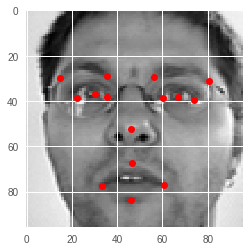

In [179]:
def show_img(img, keypoint=None):
# Sample images
  img = img.reshape(96,96)
  
  if keypoint is not None:
    x = []
    y = []
    for i in range(0,30,2):
        x.append(keypoint[i])
        y.append(keypoint[i+1])

    print(x,y)
    plt.figure()
    plt.plot(x,y, marker='o',linestyle='', color='r', label = "keypoints",)
  plt.imshow(img, cmap='gray')
  

import random
k = random.randint(0,2000)
t_img = train_images[k]
t_kpnts = train_key_points_y[k]
show_img(t_img, t_kpnts)

## Data Preprocessing 
### 1- data augemntation
### 2- Gaussian blur of image 
### 3- Histogram stretching

In [0]:
def data_augmentation(img_data, img_keypoints):
  new_data = list(img_data.copy())
  new_keypoints = list(img_keypoints.copy())
  for img, keypnt in zip(img_data.copy(), img_keypoints.copy()):
    new_data.append(cv2.flip(img, 1).reshape(96,96,1))
    p = []
    for i in range(0,30):
      if i%2 == 0:
        p.append(96 - keypnt[i])
      else:
        p.append(keypnt[i])
    new_keypoints.append(np.array(p))
    p = []
    
  return np.array(new_data), (np.array(new_keypoints) - 48 )/48

train_images_1, train_keypoints_1 = data_augmentation(train_images, train_key_points_y)

### Data Augmentation

[-0.39193328 -0.20605834  0.37526667 -0.22840333 -0.25041668 -0.19860999
 -0.54090007 -0.17626333  0.26353335 -0.20605834  0.53913335 -0.19860999
 -0.17591667 -0.39227001 -0.6824166  -0.35502668  0.26353335 -0.39971832
  0.6881     -0.37737334  0.04008333  0.09188334 -0.26530004  0.60581668
  0.30823334  0.61326663  0.0326333   0.40471665  0.04008333  0.73989995]
[29.18720245361328, 66.0128002166748, 35.97999954223633, 22.03679656982422, 60.649600982666016, 73.8784008026123, 39.555999755859375, 15.244003295898438, 60.649600982666016, 81.02880001068115, 49.92399978637695, 35.26559829711914, 62.79520034790039, 49.56639862060547, 49.92399978637695] [38.10919952392578, 37.03664016723633, 38.46672058105469, 39.53936004638672, 38.10919952392578, 38.46672058105469, 29.171039581298828, 30.95871925354004, 28.813520431518555, 29.886079788208008, 52.410400390625, 77.0792007446289, 77.43679809570312, 67.42639923095703, 83.51519775390625]


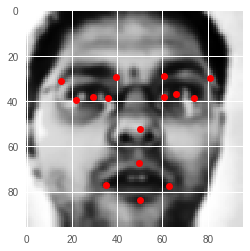

In [188]:
print(train_keypoints_1[k+2140])
show_img(train_images_1[k+2140],train_keypoints_1[k+2140]*48+48)

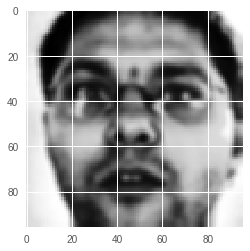

In [185]:
# Histogram stretching and blur
from skimage import exposure
t_img_1 = cv2.GaussianBlur(t_img,(5,5),0)
img_eq = exposure.equalize_hist(t_img_1)
show_img(img_eq)


for i in range(len(train_images)):
  t_img_1 = cv2.GaussianBlur(train_images[i],(5,5),0)
  img_eq = exposure.equalize_hist(t_img_1)
  train_images[i,:,:,:] = img_eq.reshape(96,96,1)


## Building The Model

In [29]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten

Using TensorFlow backend.


In [0]:
def create_model_1(inpt=28):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                              activation='relu', input_shape=(inpt, inpt, 1)))
  model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                              activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                              activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                              activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(30, activation="linear"))

  return model

In [213]:
model = create_model(96)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 96, 96, 32)        832       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 96, 96, 32)        25632     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 24, 24, 64)        0         
__________

In [0]:
# model.load_weights('drive/data/facial_keypoint_weights.h5')
# del model

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.96, nesterov=True)
model.compile(optimizer='sgd', loss='mse', metrics=['mae', 'accuracy'])
json_model = model.to_json()

# with open("model.json", "w") as json_file:
#     json_file.write(json_model)
    


In [216]:
epochs = 100
history = model.fit(train_images, train_keypoints, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0551 - mean_absolute_error: 0.1832 - acc: 0.2255 - val_loss: 0.0359 - val_mean_absolute_error: 0.1531 - val_acc: 0.4393
Epoch 2/100
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.1488 - acc: 0.2839 - val_loss: 0.0286 - val_mean_absolute_error: 0.1359 - val_acc: 0.4393
Epoch 3/100
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0308 - mean_absolute_error: 0.1394 - acc: 0.3049 - val_loss: 0.0293 - val_mean_absolute_error: 0.1386 - val_acc: 0.4439
Epoch 4/100
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0282 - mean_absolute_error: 0.1333 - acc: 0.3563 - val_loss: 0.0269 - val_mean_absolute_error: 0.1317 - val_acc: 0.4603
Epoch 5/100
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0260 - mean_absolute_error: 0.1282 - acc: 0.3452 - val_loss: 0.0270 - val_mean

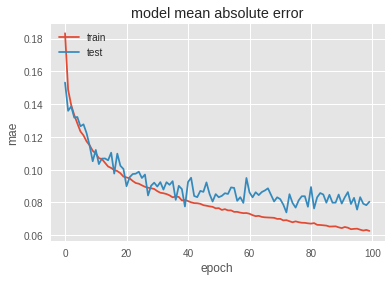

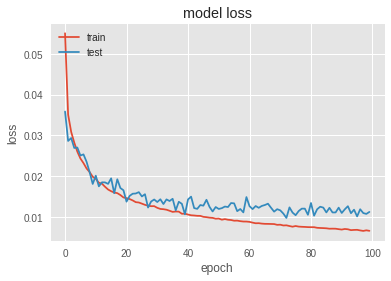

In [217]:
def visualize(history):
  plt.plot(history.history['mean_absolute_error'])
  plt.plot(history.history['val_mean_absolute_error'])
  plt.title('model mean absolute error')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
visualize(history)

In [218]:
img = test_images[0]
pre = model.predict(np.array([img]))
print(pre.shape)

(1, 30)


In [219]:
k = pre.reshape(-1,1)
k.shape

(30, 1)

[array([63.38857], dtype=float32), array([33.005672], dtype=float32), array([57.951218], dtype=float32), array([70.35718], dtype=float32), array([37.84366], dtype=float32), array([25.554531], dtype=float32), array([54.92872], dtype=float32), array([75.338104], dtype=float32), array([40.669155], dtype=float32), array([20.147215], dtype=float32), array([47.8774], dtype=float32), array([60.756973], dtype=float32), array([35.114986], dtype=float32), array([47.50558], dtype=float32), array([47.69186], dtype=float32)] [array([38.799553], dtype=float32), array([38.941917], dtype=float32), array([39.83293], dtype=float32), array([39.446785], dtype=float32), array([40.04092], dtype=float32), array([39.199566], dtype=float32), array([31.525223], dtype=float32), array([32.06559], dtype=float32), array([31.962255], dtype=float32), array([33.157677], dtype=float32), array([55.210148], dtype=float32), array([72.07354], dtype=float32), array([71.45054], dtype=float32), array([68.306046], dtype=float3

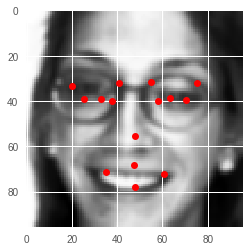

In [225]:
import random
k = random.randint(0, train_images.shape[0])
img = train_images[k]
pre = model.predict(np.array([img]))
pre = pre.reshape(-1,1)
pre = pre*48+48
show_img(img, pre)

# Advanced Pre-processing

1. LBP - Local Binary Patterns
2. PCA - Principle Component Analysis

## 1- Using LBP to remove noise

The first step in constructing the LBP texture descriptor is to convert the image to grayscale. For each pixel in the grayscale image, we select a neighborhood of size r surrounding the center pixel. A LBP value is then calculated for this center pixel and stored in the output 2D array with the same width and height as the input image.

For example, let’s take a look at the original LBP descriptor which operates on a fixed 3 x 3 neighborhood of pixels just like this:

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2015/12/lbp_thresholding.jpg)

Image Source - https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

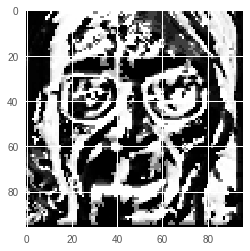

In [40]:
from skimage.feature import local_binary_pattern

def get_lbp_features(img):
  radius = 3
  n_points = 8*3
  METHOD = 'default'

  lbp_features = local_binary_pattern(img, n_points, radius, METHOD)
  return lbp_features

img = train_images[48].reshape(96,96)
img_lbp_features = get_lbp_features(img)
show_img(img_lbp_features)

In [41]:
img_lbp_features

array([[2.8835840e+06, 3.9321600e+05, 6.5536000e+04, ..., 6.1440000e+04,
        0.0000000e+00, 5.2019200e+05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.6009600e+05,
        0.0000000e+00, 2.6009600e+05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1366400e+05,
        0.0000000e+00, 2.6112000e+05],
       ...,
       [1.2583039e+07, 1.2583143e+07, 4.1943040e+06, ..., 6.5408000e+04,
        6.5376000e+04, 3.2704000e+04],
       [8.3887350e+06, 8.3888630e+06, 8.3887340e+06, ..., 1.6256000e+04,
        1.6352000e+04, 1.6192000e+04],
       [1.2700000e+02, 3.1000000e+01, 5.1100000e+02, ..., 8.0640000e+03,
        8.1600000e+03, 8.0000000e+03]])

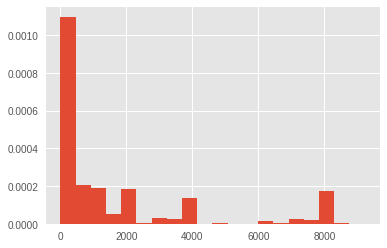

In [42]:
img_lbp_features/=255
plt.hist(img_lbp_features.ravel(), normed=True, bins=20, range=(0, 96*96))
plt.show()


In [0]:
lbp_train_imgs = []
for img in train_images_1:
  img = train_images[k].reshape(96,96)
  img_lbp_features = get_lbp_features(img)
  lbp_train_imgs.append(img_lbp_features)
lbp_train_imgs = np.array(lbp_train_imgs)

## 2 - Using PCA to reduce dimension
Creating eigen faces using principle component analysis

In [189]:
reformed_imgs = train_images.reshape(-1, 96*96)
reformed_imgs.shape

(2140, 9216)

In [190]:
reformed_imgs[0]

array([0.9955025 , 0.995673  , 0.9963195 , ..., 0.18057017, 0.21513902,
       0.23113212], dtype=float32)

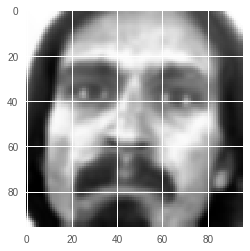

In [191]:
show_img(reformed_imgs[0])

In [192]:
from sklearn.decomposition import PCA

h, w = 28, 28

pca = PCA(n_components=h*w, whiten=True, svd_solver='auto')

%time pca_train_images = pca.fit_transform(reformed_imgs)

CPU times: user 18.2 s, sys: 3.29 s, total: 21.4 s
Wall time: 11.6 s


In [193]:
print("variance/ information retrieved ",pca.explained_variance_ratio_.cumsum()[-1]*100)

variance/ information retrieved  99.74417686462402


In [194]:
pca_train_images = pca_train_images.reshape(-1, h, w, 1)
pca_train_images.shape
# 28**2

(2140, 28, 28, 1)

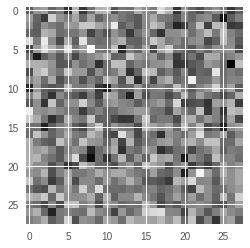

In [195]:
plt.imshow(pca_train_images[0].reshape(h, w), cmap='gray')

In [197]:
model1 = create_model(inpt = 16)
model1.summary()

# sgd = optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.96, nesterov=True)
model1.compile(optimizer='sgd', loss='mse', metrics=['mae', 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 7, 7, 64)          0         
__________

In [199]:
epochs = 500
history1 = model1.fit(pca_train_images, train_keypoints, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=64)

Train on 1712 samples, validate on 428 samples
Epoch 1/500
1712/1712 [==============================] - 1s 310us/step - loss: 0.0053 - mean_absolute_error: 0.0555 - acc: 0.7360 - val_loss: 0.0085 - val_mean_absolute_error: 0.0688 - val_acc: 0.4322
Epoch 2/500
1712/1712 [==============================] - 1s 307us/step - loss: 0.0054 - mean_absolute_error: 0.0559 - acc: 0.7325 - val_loss: 0.0085 - val_mean_absolute_error: 0.0687 - val_acc: 0.4322
Epoch 3/500
1712/1712 [==============================] - 1s 304us/step - loss: 0.0054 - mean_absolute_error: 0.0557 - acc: 0.7208 - val_loss: 0.0085 - val_mean_absolute_error: 0.0688 - val_acc: 0.4322
Epoch 4/500
1712/1712 [==============================] - 1s 305us/step - loss: 0.0054 - mean_absolute_error: 0.0556 - acc: 0.7150 - val_loss: 0.0085 - val_mean_absolute_error: 0.0688 - val_acc: 0.4322
Epoch 5/500
1712/1712 [==============================] - 1s 310us/step - loss: 0.0053 - mean_absolute_error: 0.0555 - acc: 0.7354 - val_loss: 0.0085 

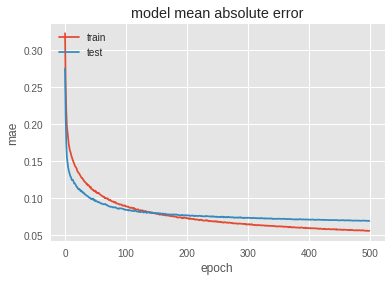

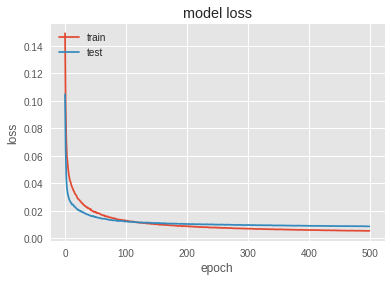

In [153]:
visualize(history1)

[array([65.72066], dtype=float32), array([29.899155], dtype=float32), array([59.163525], dtype=float32), array([72.80745], dtype=float32), array([36.57542], dtype=float32), array([23.137798], dtype=float32), array([56.08385], dtype=float32), array([78.92258], dtype=float32), array([39.543022], dtype=float32), array([16.404617], dtype=float32), array([47.93137], dtype=float32), array([62.707855], dtype=float32), array([33.35858], dtype=float32), array([47.89337], dtype=float32), array([48.048347], dtype=float32)] [array([37.10556], dtype=float32), array([37.095848], dtype=float32), array([38.03533], dtype=float32), array([37.973373], dtype=float32), array([38.026848], dtype=float32), array([38.14631], dtype=float32), array([29.201595], dtype=float32), array([30.063385], dtype=float32), array([29.388582], dtype=float32), array([30.829767], dtype=float32), array([56.432217], dtype=float32), array([75.04819], dtype=float32), array([75.15921], dtype=float32), array([71.043594], dtype=float3

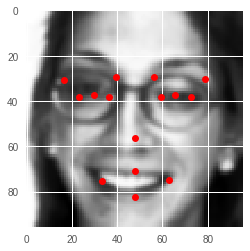

In [226]:
import random
img = train_images[k]
img1 = pca.transform(img.reshape(1, -1))
pre = model1.predict(img1.reshape(-1, 28, 28, 1))
pre = pre.reshape(-1,1)
pre = pre*48+48
show_img(img, pre)